# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
#lemmatize
import nltk
from nltk import word_tokenize 
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stop_words]
    
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())
        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='ascii', ngram_range=(1,2), max_df = 0.5, min_df = 5, lowercase=True, stop_words=tokenized_stop_words)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['exclam_count'] = movie_data['review'].str.count("\!")
    movie_data['q_count'] = movie_data['review'].str.count("\?")
    movie_data['q_star'] = movie_data['review'].str.count("\*")
    movie_data['q_hash'] = movie_data['review'].str.count("\#")
    
    # uppercase letter count
    import string
    movie_data['upper'] = [sum(1 for letter in c if letter.isupper()) for c in movie_data['review']]
    
    #afinn sentiment dictionary score from modifierd dictionary of only negative sentiment words
    from afinn import Afinn
    afn = Afinn()
    
    movie_data['afinn_score'] = [afn.score(c) for c in movie_data['review']]

    X_quant_features = movie_data[["word_count", "punc_count",'exclam_count','q_count','upper','q_star','q_hash','afinn_score']]
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=80)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 115664)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         433          20             1        2     59       0       0   
1     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 4730, 'TN': 5150, 'FP': 4893, 'FN': 5227, 'Accuracy': 0.494, 'Precision': 0.49153070767951784, 'Recall': 0.47504268353921864, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=5, max_iter=10000, early_stopping=True)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9865, 'TN': 9928, 'FP': 115, 'FN': 92, 'Accuracy': 0.98965, 'Precision': 0.9884769539078156, 'Recall': 0.9907602691573767, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',alpha=1, early_stopping=True)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9864, 'TN': 9938, 'FP': 105, 'FN': 93, 'Accuracy': 0.9901, 'Precision': 0.9894673487812218, 'Recall': 0.9906598373003916, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9835, 'TN': 9960, 'FP': 83, 'FN': 122, 'Accuracy': 0.98975, 'Precision': 0.9916313772938092, 'Recall': 0.9877473134478256, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron',alpha=1)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9956, 'TN': 10043, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.999899568143015, 'desc': 'prc_train'}


### Model: Neural Network Perceptron

In [10]:
# from sklearn import neural_network

# prc = neural_network.MLPClassifier()
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=1000, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9834, 'TN': 10028, 'FP': 15, 'FN': 123, 'Accuracy': 0.9931, 'Precision': 0.9984770027413951, 'Recall': 0.9876468815908406, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

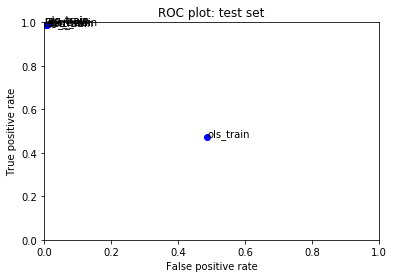

In [13]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [14]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
5
In the ravaged wasteland of the future, mankind is terrorized by Cyborgsrobots with human featuresthat have discovered a new source of fuel: human blood. Commanded by their vicious leader Jōb (Lance Henriksen), the Cyborgs prepare to overtake Taos, a densely populated human outpost.<br /><br />Only one force can stop Jōb's death marchthe Cyborg Gabriel (Kris Kristofferson), who is programmed to destroy Jōb and his army.<br /><br />In the ruins of a ransacked village, Gabriel finds Nea (Kathy Long), a beautiful young woman whose parents were killed by Cyborgs ten years earlier. Now she wants revenge. They strike a pact: Gabriel will train Nea how to fight the Cyborgs and Nea will lead Gabriel to Taos.<br /><br />Five-time kick-boxing champion Kathy Long has all the right moves in this high-speed adventure that delivers plenty of action. Also stars Gary Daniels (as David) and Scott Paulin (as Simon).
* * * * * * * * * 
49
I was very disappointed in this 

624
The movie opens with a flashback to Doddsville County High School on April Fool's Day. A group of students play a prank on class nerd Marty. When they are punished for playing said prank, they follow up with a bigger prank which (par for the course in slasher films involving pranks on class nerds) goes ridiculously awry leaving Marty simultaneously burned by fire and disfigured by acid for the sake of being thorough. Fast forward five years, where we find members of the student body gathering at the now abandoned high school for their five year class reunion. We find out that it is no coincidence that everyone at the reunion belonged to the clique of pranksters from the flashback scene, as all of the attendees are being stalked and killed by a mysterious, jester mask-clad murderer in increasingly complicated and mind-numbingly ludicrous fashions. It doesn't take Sherlock Holmes to solve the mystery of the killer's identity, as it is revealed to be none other than a scarred Marty wh

3594
Run away from this movie. Even by B-movie standards this movie is dreadful. It is also insidious in it's theme. The main theme is that people who reject society and have no respect for anything are cool and worth admiring. People who treat others with respect are losers. Guncrazy is a movie that speaks for the disenfranchised a lot better than this movie, see it instead.<br /><br />No normal kid would do what Trent does. State Troopers do not work as they do in this film etc. Seeing this movie makes you realize why writers use the hooker-with-a-heart-of-gold cliche. Mija is a completely unsympathetic hooker,who yes, has had a terrible life. However, she is such a terrible person the audience cannot identify with her.<br /><br />Usually there is one thing a movie can be recommended for, in this case there is none. It is such a ridiculous movie it insults the person who tries to identify with the main characters. The acting is adequate by B-movie standards and the direction presents

4179
DVD has become the equivalent of the old late night double-bill circuit, the last chance to catch old movies on the verge of being completely forgotten like The Border. There were great expectations for this back in 1982  a script co-written by The Wild Bunch's Walon Green, Jack Nicholson in the days when he could still act without semaphore and a great supporting cast (Harvey Keitel, Warren Oates, Valerie Perrine), Tony Richardson directing (although he was pretty much a spent force by then)  but now it doesn't even turn up on TV. The material certainly offers a rich seam of possibilities for comment on the 80s American Dreams of capitalism and conspicuous consumption, with Nicholson's border patrolman turning a blind eye to the odd drug deal or bit of people trafficking to finance his wife's relentless materialism, until he rediscovers his conscience when he finds out his partners are also in the baby selling business. Unfortunately, he never really gets his hands dirty, barel

6623
Having watched this movie on the SciFi channel, I can only conclude that this film was made by a bunch of amateurs who have never seen a movie in their lives. The film is an endless sequence of bizarre occurrences, or \delights\" as the friend reading over my shoulder is telling me. The plot isn't really worth commenting as, but basically a plane carrying football players crashes into Yeti territory. Before the movie is over, we are treated to yetis ripping hearts out, yetis waddling in an effort to run before jumping 50 meters, yetis ripping a man's legs off and beating him with them, a woman killing a rabbit at 30 meters with a javelin, a yeti surviving several bullets and being set on fire with no apparent harm, a yeti dangling off a cliff by holding to a man's shoe, yet then jumps off, and a whole collection of further, bizarre occurrences. Basically, if you aren't staying up on a Saturday for the expressed purpose of watching the worst of SciFi channel original movies, avoid 

7691
This film is terrible. Every line is stolen from 8MM (the Italian dubbed version, at least). If you like trash... real trash, give it a try; but beware: this ain't the \so bad it's good\" kind of flick. In its cheapness, it may really look like a porno but, believe me, if you're looking for \"snuff\", s & m, hardcore, softcore... or even an ordinary erotic thriller, go find something else in store! I'm telling you this, 'cause the absolutely uninspired and unconvincing shooting, acting, plot, dialogues (the only good lines, as I said before, are the ones they stolen from Joel Schumacher's 8MM!) will bore you to tears in a few minutes and the \"happy ending\" is absolutely revolting! I'll give it one star: a half for the sudden shot in the back scene, after \"the eyes of the victim\" monologue (stolen from 8MM as well) and a half for mom & daughter's sexy bodies (that didn't manage to keep me completely awake while watching this turkey, anyway!)"
* * * * * * * * * 
7828
It is hard 

9620
Let's start by the simple lines. From the viewer's side, there a couple of good \director details\", some points of view at the movie scenes that are nice. The special effects are good enough, a good acting/good scenery also. But the story is way too simple. It shows how a elite Army bomb squad unit lives, acts and sometimes dies. It shows the drama of living in war. In my movie experience as a serious action movie \"addicted\" guy, I missed that click that gets my eyes and mind stuck on the screen. One of the things that need to be present in a movie in order to I consider it a good one is the ability of immerse the viewer in the movie reality and time. It didn't happened to me. I stayed \"conscious\", for the entire movie.<br /><br />Honestly speaking, I think that this movie gained its place in fame based on the \"subconscious\" appeal of American patriotism, a healthy and genuine feeling, but not the adequate use as a movie fame generator. More than a movie about war, it grows

10765
Ever since the cinema-loving universe made acquaintance with a guy named George A. Romero, the word \zombie\" automatically gets associated with blood-soaked horror images and non-stop acting sequences. It's safe to say that his \"Night of the Living Dead\" formed the zombie movie as we know it now. Yet, in the earliest years of cinema, the premise of reanimated corpses was merely used in slow, nearly action-less psychological thrillers. Jacques Tourneur's \"I walked with a Zombie\" is a perfect example and so is \"White Zombie\", starring Bela Lugosi. This \"Revolt of the Zombies\" could have been another example but unfortunately it's a failure over the entire line and easily one of the most tedious movies I ever saw. Dreadful acting, a very poorly written screenplay and a complete lack of atmosphere and tension! The film only lasts 65 minutes and yet the first half hour is entirely wasted on stupid love-story intrigues and unexciting monologues. The setting in the legendary Ca

12771
Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it.
* * * * * * * * * 
12851
I can say without a shadow of a doubt that Going Overboard is the single worst film i have ever seen, and yes, I have seen Cujo. Adam Sandler is an abomination as Schecky Moskowitz, a wannabe comedian working on a cruise liner. That's the plot.<br /

13826
The film is pretty confusing and ludicrous. The plot is awful...but on the plus side the acting is pretty good, with a few good shouts and rants. Sharon stone is OK this time...not even half as good as the original mind you. The murders aren't as gory as the first one either, which is a shame. Its not the unpredictable mess everyone say it is though. The sex is pretty graphic at times while others it is clear it is fake (they are fully clothed). The script is weak most of the time, but the scenes with banter and arguments between Dr.Glass and Washburn are highlights. The plot twists a few times, but the ending is awful. The tension is always constant with a huge dollop of 'Oh my god!'. The chase sequences are brilliantly directed, and shots and camera angles are impressive and bring a bit of class to an otherwise, rush-felt film. Sharon stone is a bit old for this too. The bits where we see her breasts were, in the first one, delights. This time around, they are too horrid to des

15908
This movie blows - let's get that straight right now. There are a few scene gems nestled inside this pile of crap but none can redeem the limp plot. Colin Farrel looks like Brad Pitt in \12 Monkeys\" and acts in a similar manner. I normally hate Colin because he is a fairy in general but he's OK in this movie. There were two plot lines in this movie-= one about a kid who throws rocks through windshields of moving vehicles and the other about a woman with a moustache. Let's face it- this movie has no freaking idea of what it wanted to say or where it wanted to go. THe characters story lines intertwine on some levels but are in no means worthy of being included in a script. The whole thing is weak and pointless and then there is an occasional OK scene. But overall- Don't bother unless you love irish accents so much that you can watch mediocrity and it is rescued by everyone sounding like the Lucky Charms elf -an American fetish that has catapulted some truly crappy movies to succes

17036
NATIONAL LAMPOON'S CLASS REUNION was a flop when it was released. It didn't stay long in theaters in my big city. Why? Because it's BAD!!!!!<br /><br />Not bad in a good way but bad in a really painfully unfunny way. The entire cast of actors were mostly unknowns then and have remained unknowns after this turkey.<br /><br />The idea is actually great (a parody of slasher flicks) but the execution is sorely lacking in every aspect. <br /><br />Just avoid this \comedy\". Your time is more precious than spending a nanosecond watching this embarrassing misfire."
* * * * * * * * * 
17141
Hmm I agree with the reviewer who said that \strange people with generous tastes have been reviewing this film\". I thought the film was intriguing enough to watch it. I think that was primarily because of Marsden and Speedman - not the plot.<br /><br />The bottom line is that this film is mildly psychologically tantalizing on the one hand and profoundly homophobic on the other. Thumbs up on the form

19371
If they could get Ed Asner why didn't they get other actors instead of people who go to the same church as the producers? And why did the protagonist throw the wise old sage character to the ground when he was never in danger. It forced the old guy to mask the injury out of pride and so the young guy would feel guilty leaving him with a life long disability. I guess thats why the main character refuses money though and why the old guy works him like a dog even when he volunteers for extra work. If the d-bag boyfriend is a bad guy because he is long-distance boyfriend then why is a soldier any better. He has good reason to be jealous, good reason to get her away from her hometown and over protective, controlling manipulative father. All the characters that are meant to be likable aren't and everyone else is the 'bad' boyfriend. How did they meet anyway, a wine broker and a saw mill worker?
* * * * * * * * * 
19402
Now, i hired this movie because Brad Dourif was in it. He is an exc

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [16]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1166, 'TN': 1319, 'FP': 1138, 'FN': 1377, 'Accuracy': 0.497, 'Precision': 0.5060763888888888, 'Recall': 0.4585135666535588, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2283, 'TN': 2183, 'FP': 274, 'FN': 260, 'Accuracy': 0.8932, 'Precision': 0.892843175596402, 'Recall': 0.897758552890287, 'desc': 'svm_test'}


### MODEL: logistic regression

In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2281, 'TN': 2210, 'FP': 247, 'FN': 262, 'Accuracy': 0.8982, 'Precision': 0.9022943037974683, 'Recall': 0.8969720802202124, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2123, 'TN': 2089, 'FP': 368, 'FN': 420, 'Accuracy': 0.8424, 'Precision': 0.8522681653954235, 'Recall': 0.8348407392843099, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2153, 'TN': 2097, 'FP': 360, 'FN': 390, 'Accuracy': 0.85, 'Precision': 0.8567449263828094, 'Recall': 0.8466378293354306, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2234, 'TN': 2213, 'FP': 244, 'FN': 309, 'Accuracy': 0.8894, 'Precision': 0.9015334947538337, 'Recall': 0.8784899724734565, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1761, 'TN': 2077, 'FP': 380, 'FN': 782, 'Accuracy': 0.7676, 'Precision': 0.8225128444652032, 'Recall': 0.6924891860007865, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

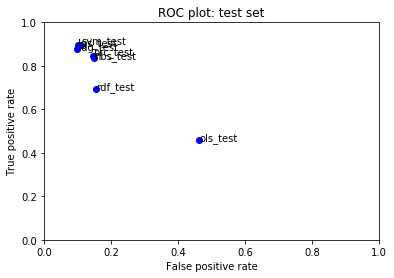

In [23]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [34]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=80, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 115664)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         131           5             0        0      7       0       0   
1         169          15             1        0     15       0       0   
2         176          18             0        0     25       0  

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [35]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4916


In [36]:
raw_data.head()

,id,review,word_count,punc_count,exclam_count,q_count,q_star,q_hash,upper,afinn_score
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,0,0,0,7,17.0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1,0,0,0,15,22.0
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0,0,0,0,25,7.0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0,0,0,0,10,10.0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0,0,0,0,17,3.0


In [37]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [38]:
my_submission.shape

(25000, 2)

In [39]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation